# Actividad 9: Árbol de Decisión - Detección de Phishing

**Objetivo:** Implementar un modelo de aprendizaje supervisado usando árbol de decisión para clasificar si un correo electrónico o mensaje SMS es **Phishing o Legítimo**.

## 🎯 Problema a Resolver

En el campo de la **ciberseguridad**, el phishing es una de las amenazas más comunes. Los atacantes envían correos o mensajes fraudulentos que parecen legítimos para robar información sensible (contraseñas, datos bancarios, etc.).

Este modelo analizará mensajes y determinará si son **Phishing** o **Legítimos** basándose en sus características.

## Variables del Modelo

### Variables Independientes (Predictoras):
1. **Remitente Sospechoso** (remitente_sospechoso): Nivel de sospecha del remitente (0-10)
2. **Contiene URL** (contiene_url): ¿El mensaje contiene enlaces? (0=No, 1=Sí)
3. **Dominio Sospechoso** (dominio_sospechoso): ¿El dominio de la URL es sospechoso? (0-10)
4. **Urgencia/Amenaza** (tono_urgencia): ¿Usa tono de urgencia o amenaza? (0-10)
5. **Solicita Información** (solicita_info): ¿Pide información personal/contraseñas? (0-10)
6. **Errores Gramaticales** (errores_gramaticales): Cantidad de errores (0-10)
7. **Oferta Irreal** (oferta_irreal): ¿Promete premios/ofertas increíbles? (0-10)

### Variable Dependiente (Objetivo):
- **Es Phishing** (es_phishing): 1 = Phishing, 0 = Legítimo

## 1. Importación de Librerías

In [1]:
# Instalación de librerías necesarias (ejecutar solo una vez)
# !pip install pandas numpy scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

print("✓ Librerías importadas correctamente")
print("✓ Listo para detectar phishing 🛡️")

✓ Librerías importadas correctamente
✓ Listo para detectar phishing 🛡️


## 2. Generación del Dataset

Vamos a generar un dataset sintético de **1200 mensajes** (emails y SMS) con características realistas de mensajes de phishing y legítimos.

In [3]:
# Configuración del generador de números aleatorios
np.random.seed(42)

# Número de registros
n_records = 1200

# Generar dos grupos: legítimos (60%) y phishing (40%)
n_legitimate = int(n_records * 0.6)  # 720 mensajes legítimos
n_phishing = n_records - n_legitimate  # 480 mensajes de phishing

print("🔍 Generando dataset de mensajes...\n")

# ============================================
# MENSAJES LEGÍTIMOS (puntuaciones bajas)
# ============================================
legitimate_data = {
    'remitente_sospechoso': np.random.normal(2, 1.5, n_legitimate).clip(0, 10),
    'contiene_url': np.random.choice([0, 1], n_legitimate, p=[0.4, 0.6]),
    'dominio_sospechoso': np.random.normal(1.5, 1.2, n_legitimate).clip(0, 10),
    'tono_urgencia': np.random.normal(2, 1.5, n_legitimate).clip(0, 10),
    'solicita_info': np.random.normal(1, 1.2, n_legitimate).clip(0, 10),
    'errores_gramaticales': np.random.normal(1, 1, n_legitimate).clip(0, 10),
    'oferta_irreal': np.random.normal(0.5, 0.8, n_legitimate).clip(0, 10)
}

# ============================================
# MENSAJES PHISHING (puntuaciones altas)
# ============================================
phishing_data = {
    'remitente_sospechoso': np.random.normal(7, 2, n_phishing).clip(0, 10),
    'contiene_url': np.random.choice([0, 1], n_phishing, p=[0.1, 0.9]),  # 90% contienen URL
    'dominio_sospechoso': np.random.normal(7.5, 1.8, n_phishing).clip(0, 10),
    'tono_urgencia': np.random.normal(7.5, 1.5, n_phishing).clip(0, 10),
    'solicita_info': np.random.normal(7, 2, n_phishing).clip(0, 10),
    'errores_gramaticales': np.random.normal(6, 2, n_phishing).clip(0, 10),
    'oferta_irreal': np.random.normal(6.5, 2, n_phishing).clip(0, 10)
}

# Crear DataFrames separados
df_legitimate = pd.DataFrame(legitimate_data)
df_legitimate['es_phishing'] = 0

df_phishing = pd.DataFrame(phishing_data)
df_phishing['es_phishing'] = 1

# Combinar y mezclar aleatoriamente
df = pd.concat([df_legitimate, df_phishing], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Redondear valores para mejor visualización
for col in df.columns:
    if col != 'es_phishing' and col != 'contiene_url':
        df[col] = df[col].round(1)

print(f"✓ Dataset generado con {len(df)} mensajes")
print(f"\n📊 Distribución de la variable objetivo:")
print(f"\n  🟢 Mensajes legítimos: {(df['es_phishing']==0).sum()} ({(df['es_phishing']==0).mean()*100:.1f}%)")
print(f"  🔴 Mensajes de phishing: {(df['es_phishing']==1).sum()} ({(df['es_phishing']==1).mean()*100:.1f}%)")
print(f"\n✓ El dataset está balanceado para un mejor entrenamiento")

🔍 Generando dataset de mensajes...

✓ Dataset generado con 1200 mensajes

📊 Distribución de la variable objetivo:

  🟢 Mensajes legítimos: 720 (60.0%)
  🔴 Mensajes de phishing: 480 (40.0%)

✓ El dataset está balanceado para un mejor entrenamiento


In [4]:
# Visualizar primeros registros
print("\n📧 Primeros 10 mensajes del dataset:\n")
display_df = df.head(10).copy()
display_df['tipo'] = display_df['es_phishing'].map({0: '🟢 Legítimo', 1: '🔴 Phishing'})
display_df


📧 Primeros 10 mensajes del dataset:



,remitente_sospechoso,contiene_url,dominio_sospechoso,tono_urgencia,solicita_info,errores_gramaticales,oferta_irreal,es_phishing,tipo
0,6.3,1,6.3,8.1,5.2,7.9,3.0,1,🔴 Phishing
1,4.5,1,8.1,5.3,6.5,2.4,2.8,1,🔴 Phishing
2,1.4,1,0.9,0.6,2.0,2.5,0.3,0,🟢 Legítimo
3,1.9,0,1.0,0.0,1.4,0.8,1.5,0,🟢 Legítimo
4,2.5,1,1.0,2.4,0.9,0.8,0.8,0,🟢 Legítimo
5,5.7,1,6.1,8.7,8.4,4.5,5.4,1,🔴 Phishing
6,5.1,1,0.5,4.5,1.3,1.8,0.9,0,🟢 Legítimo
7,3.8,1,8.3,8.3,6.3,6.4,8.0,1,🔴 Phishing
8,0.3,1,0.9,4.3,1.0,1.5,0.3,0,🟢 Legítimo
9,6.0,0,6.8,6.4,6.1,4.1,8.8,1,🔴 Phishing


In [5]:
# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas del dataset:\n")
df.describe()


📈 Estadísticas descriptivas del dataset:



,remitente_sospechoso,contiene_url,dominio_sospechoso,tono_urgencia,solicita_info,errores_gramaticales,oferta_irreal,es_phishing
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000
mean,4.007917,0.725833,3.911167,4.198667,3.433083,3.012000,2.96650,0.400000
std,2.875941,0.446279,3.123493,2.962532,3.186164,2.803112,3.19077,0.490102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.600000,0.000000,1.300000,1.700000,0.700000,0.800000,0.30000,0.000000
50%,3.250000,1.000000,2.700000,3.300000,2.200000,1.900000,1.20000,0.000000
75%,6.500000,1.000000,6.800000,7.000000,6.200000,5.200000,5.90000,1.000000
max,10.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.00000,1.000000


In [6]:
# Guardar dataset en CSV
df.to_csv('dataset_phishing.csv', index=False)
print("✓ Dataset guardado en 'dataset_phishing.csv'")

✓ Dataset guardado en 'dataset_phishing.csv'


## 3. Análisis Exploratorio de Datos (EDA)

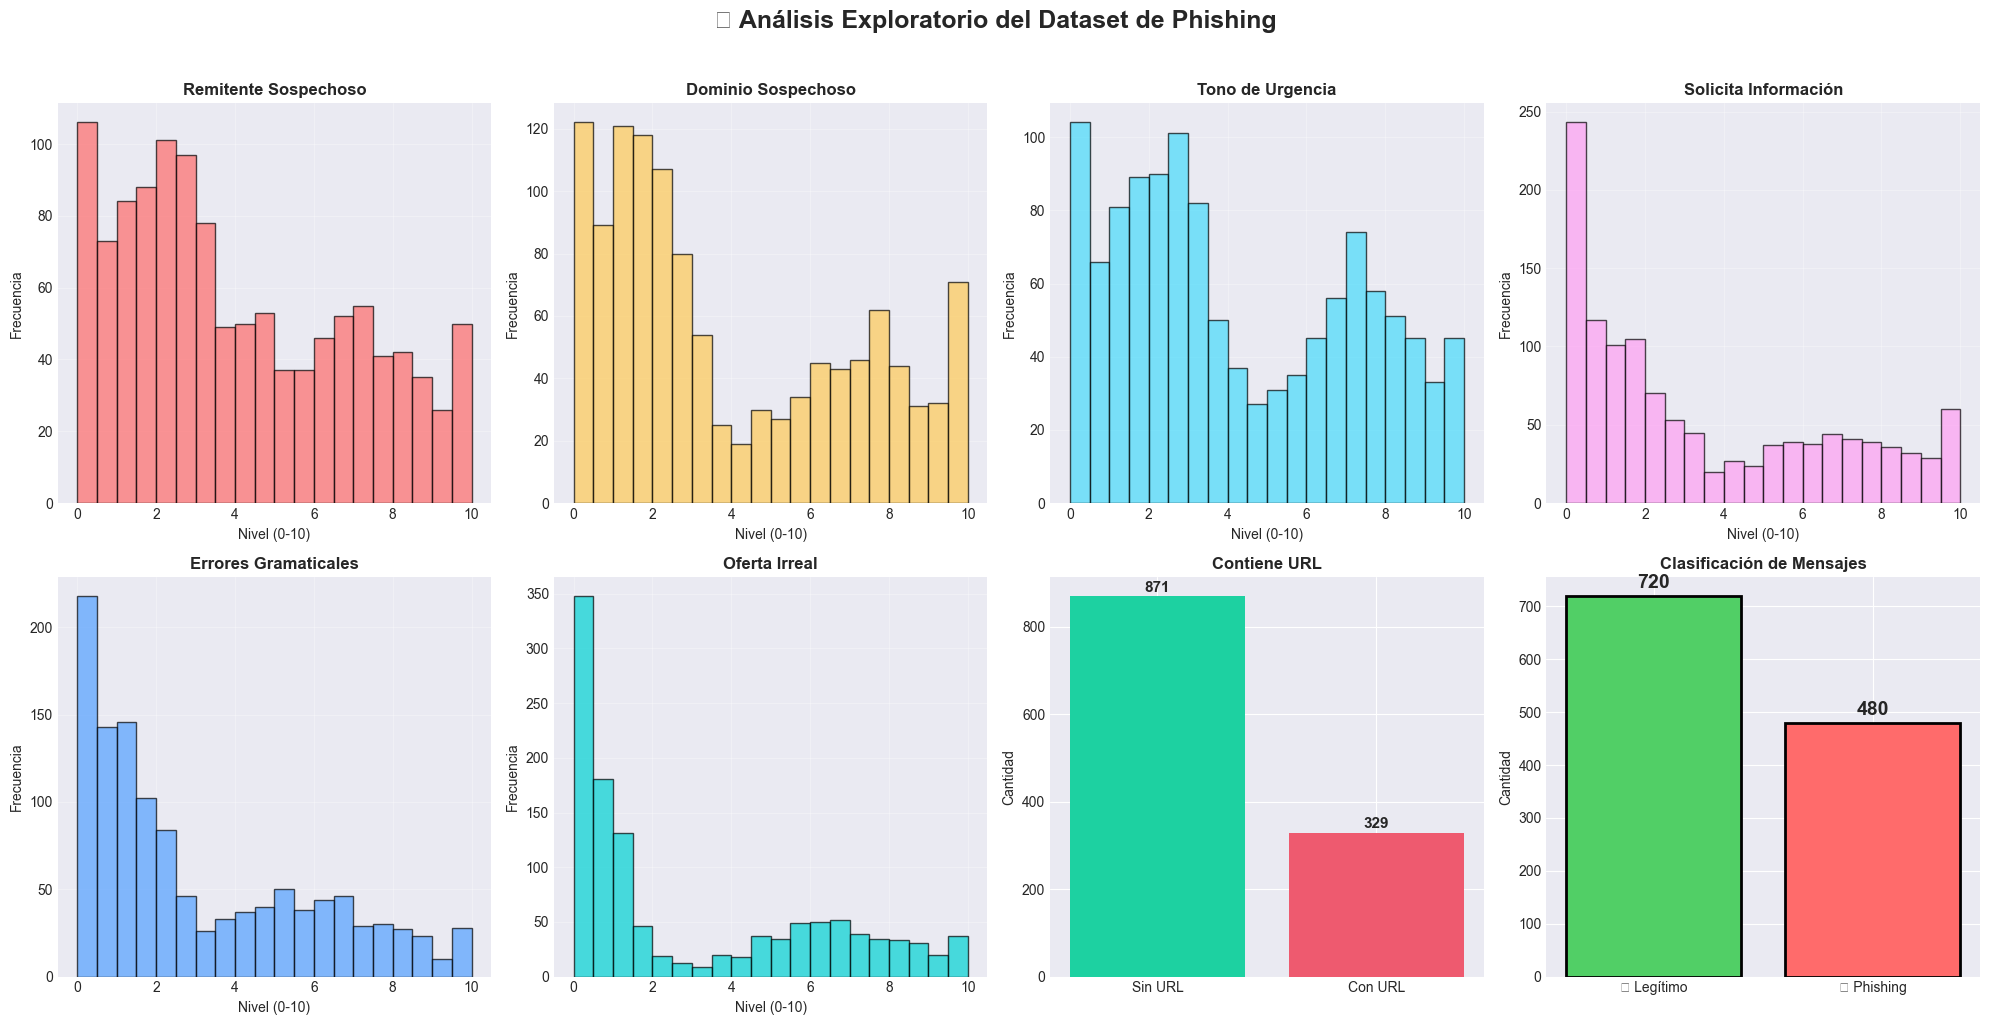

✓ Gráfico guardado: '01_analisis_exploratorio_phishing.png'


In [7]:
# Crear visualizaciones del dataset
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('🔍 Análisis Exploratorio del Dataset de Phishing', fontsize=18, fontweight='bold', y=1.02)

variables = ['remitente_sospechoso', 'dominio_sospechoso', 'tono_urgencia', 'solicita_info',
             'errores_gramaticales', 'oferta_irreal']
colors = ['#ff6b6b', '#feca57', '#48dbfb', '#ff9ff3', '#54a0ff', '#00d2d3']
titles = ['Remitente Sospechoso', 'Dominio Sospechoso', 'Tono de Urgencia', 'Solicita Información',
          'Errores Gramaticales', 'Oferta Irreal']

for idx, (var, color, title) in enumerate(zip(variables, colors, titles)):
    row = idx // 4
    col = idx % 4
    axes[row, col].hist(df[var], bins=20, color=color, edgecolor='black', alpha=0.7)
    axes[row, col].set_title(title, fontweight='bold')
    axes[row, col].set_xlabel('Nivel (0-10)')
    axes[row, col].set_ylabel('Frecuencia')
    axes[row, col].grid(True, alpha=0.3)

# Gráfico de URL
url_counts = df['contiene_url'].value_counts()
axes[1, 2].bar(['Sin URL', 'Con URL'], url_counts.values, color=['#1dd1a1', '#ee5a6f'])
axes[1, 2].set_title('Contiene URL', fontweight='bold')
axes[1, 2].set_ylabel('Cantidad')
for i, v in enumerate(url_counts.values):
    axes[1, 2].text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=11)

# Distribución de phishing vs legítimo
phishing_counts = df['es_phishing'].value_counts()
axes[1, 3].bar(['🟢 Legítimo', '🔴 Phishing'], phishing_counts.values, 
               color=['#51cf66', '#ff6b6b'], edgecolor='black', linewidth=2)
axes[1, 3].set_title('Clasificación de Mensajes', fontweight='bold', fontsize=12)
axes[1, 3].set_ylabel('Cantidad')
for i, v in enumerate(phishing_counts.values):
    axes[1, 3].text(i, v + 15, str(v), ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('01_analisis_exploratorio_phishing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '01_analisis_exploratorio_phishing.png'")

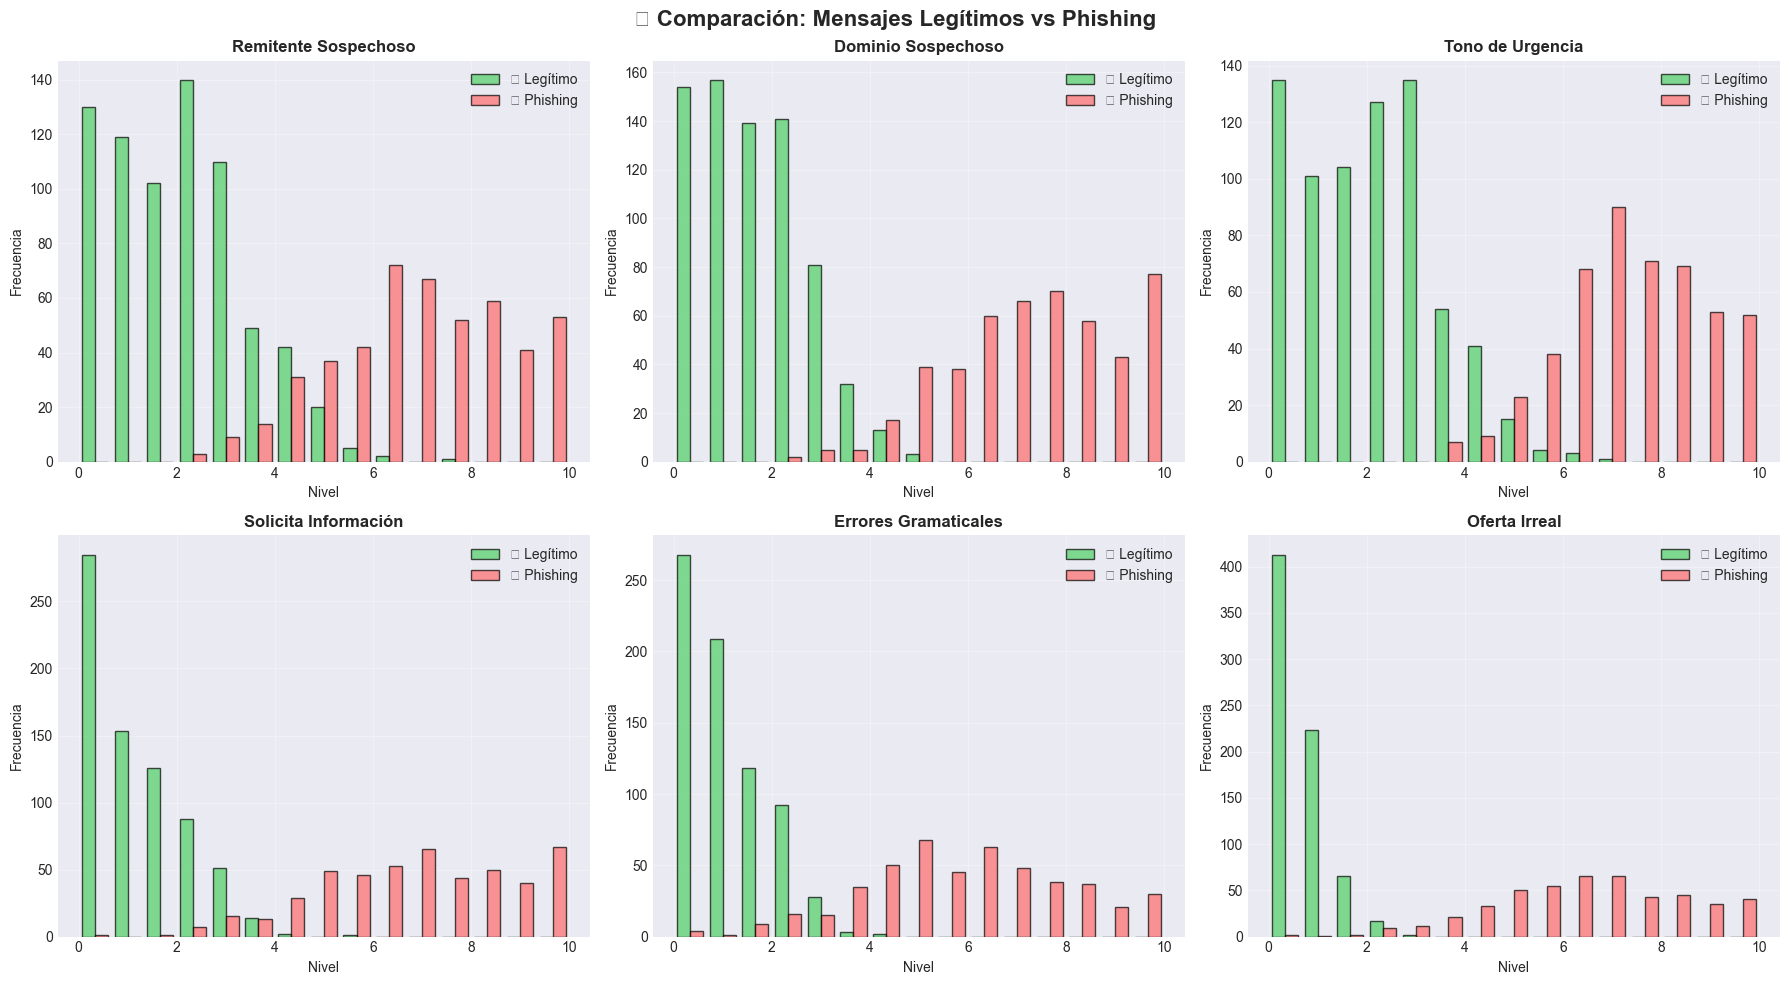

✓ Gráfico guardado: '02_comparacion_phishing_legitimo.png'


In [8]:
# Comparación: Phishing vs Legítimo
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Comparación: Mensajes Legítimos vs Phishing', fontsize=16, fontweight='bold')

variables_comp = ['remitente_sospechoso', 'dominio_sospechoso', 'tono_urgencia', 
                  'solicita_info', 'errores_gramaticales', 'oferta_irreal']
titles_comp = ['Remitente Sospechoso', 'Dominio Sospechoso', 'Tono de Urgencia',
               'Solicita Información', 'Errores Gramaticales', 'Oferta Irreal']

for idx, (var, title) in enumerate(zip(variables_comp, titles_comp)):
    row = idx // 3
    col = idx % 3
    
    # Separar datos
    legit = df[df['es_phishing']==0][var]
    phish = df[df['es_phishing']==1][var]
    
    axes[row, col].hist([legit, phish], bins=15, label=['🟢 Legítimo', '🔴 Phishing'],
                        color=['#51cf66', '#ff6b6b'], alpha=0.7, edgecolor='black')
    axes[row, col].set_title(title, fontweight='bold')
    axes[row, col].set_xlabel('Nivel')
    axes[row, col].set_ylabel('Frecuencia')
    axes[row, col].legend(loc='upper right')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_comparacion_phishing_legitimo.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '02_comparacion_phishing_legitimo.png'")

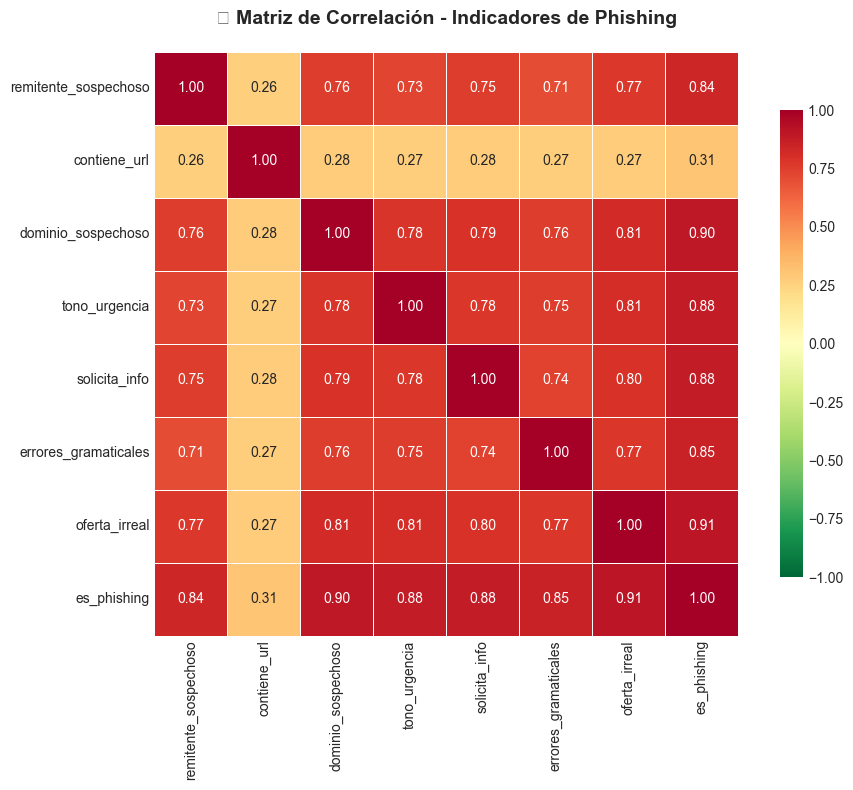

✓ Gráfico guardado: '03_matriz_correlacion_phishing.png'


In [9]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0)
plt.title('🔥 Matriz de Correlación - Indicadores de Phishing', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('03_matriz_correlacion_phishing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '03_matriz_correlacion_phishing.png'")

## 4. Preparación de Datos para el Modelo

In [10]:
# Separar características (X) y variable objetivo (y)
X = df[['remitente_sospechoso', 'contiene_url', 'dominio_sospechoso', 
        'tono_urgencia', 'solicita_info', 'errores_gramaticales', 'oferta_irreal']]
y = df['es_phishing']

print("🔍 Variables independientes (X):")
print(X.columns.tolist())
print(f"\n📊 Forma de X: {X.shape}")
print(f"📊 Forma de y: {y.shape}")

🔍 Variables independientes (X):
['remitente_sospechoso', 'contiene_url', 'dominio_sospechoso', 'tono_urgencia', 'solicita_info', 'errores_gramaticales', 'oferta_irreal']

📊 Forma de X: (1200, 7)
📊 Forma de y: (1200,)


In [11]:
# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 División de datos:")
print(f"  • Conjunto de entrenamiento: {len(X_train)} mensajes ({len(X_train)/len(X)*100:.1f}%)")
print(f"  • Conjunto de prueba: {len(X_test)} mensajes ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n  🔴 Phishing en entrenamiento: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  🔴 Phishing en prueba: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

📊 División de datos:
  • Conjunto de entrenamiento: 960 mensajes (80.0%)
  • Conjunto de prueba: 240 mensajes (20.0%)

  🔴 Phishing en entrenamiento: 384 (40.0%)
  🔴 Phishing en prueba: 96 (40.0%)


## 5. Creación y Entrenamiento del Modelo de Árbol de Decisión

In [12]:
# Crear el modelo de árbol de decisión
modelo = DecisionTreeClassifier(
    max_depth=5,           # Profundidad máxima del árbol
    min_samples_split=40,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=15,   # Mínimo de muestras en una hoja
    random_state=42,
    criterion='gini'       # Criterio de división (gini o entropy)
)

print("✓ Modelo de Árbol de Decisión creado")
print("\n⚙️ Parámetros del modelo:")
print(f"  • Profundidad máxima: {modelo.max_depth}")
print(f"  • Mínimo muestras para dividir: {modelo.min_samples_split}")
print(f"  • Mínimo muestras en hoja: {modelo.min_samples_leaf}")
print(f"  • Criterio: {modelo.criterion}")

✓ Modelo de Árbol de Decisión creado

⚙️ Parámetros del modelo:
  • Profundidad máxima: 5
  • Mínimo muestras para dividir: 40
  • Mínimo muestras en hoja: 15
  • Criterio: gini


In [13]:
# Entrenar el modelo
print("\n🎓 Entrenando el modelo de detección de phishing...")
modelo.fit(X_train, y_train)
print("✓ Modelo entrenado exitosamente")

# Información del árbol entrenado
print(f"\n🌳 Información del árbol entrenado:")
print(f"  • Número de nodos: {modelo.tree_.node_count}")
print(f"  • Número de hojas: {modelo.get_n_leaves()}")
print(f"  • Profundidad real del árbol: {modelo.get_depth()}")


🎓 Entrenando el modelo de detección de phishing...
✓ Modelo entrenado exitosamente

🌳 Información del árbol entrenado:
  • Número de nodos: 7
  • Número de hojas: 4
  • Profundidad real del árbol: 2


## 6. Evaluación del Modelo

In [14]:
# Hacer predicciones
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Calcular exactitud (accuracy)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("\n🎯 Métricas de Rendimiento del Modelo:\n")
print(f"  • Exactitud en entrenamiento: {accuracy_train*100:.2f}%")
print(f"  • Exactitud en prueba: {accuracy_test*100:.2f}%")
print(f"  • Diferencia (overfitting): {(accuracy_train-accuracy_test)*100:.2f}%")

if accuracy_test >= 0.9:
    print("\n  🏆 ¡Excelente! El modelo detecta phishing con alta precisión")
elif accuracy_test >= 0.8:
    print("\n  ✅ Muy bien! El modelo es confiable para detección")
else:
    print("\n  ⚠️ El modelo necesita más ajustes")


🎯 Métricas de Rendimiento del Modelo:

  • Exactitud en entrenamiento: 99.27%
  • Exactitud en prueba: 98.33%
  • Diferencia (overfitting): 0.94%

  🏆 ¡Excelente! El modelo detecta phishing con alta precisión


In [15]:
# Reporte de clasificación
print("\n📋 Reporte de Clasificación (Conjunto de Prueba):\n")
print(classification_report(y_test, y_pred_test, target_names=['🟢 Legítimo', '🔴 Phishing']))


📋 Reporte de Clasificación (Conjunto de Prueba):

              precision    recall  f1-score   support

  🟢 Legítimo       0.99      0.99      0.99       144
  🔴 Phishing       0.98      0.98      0.98        96

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



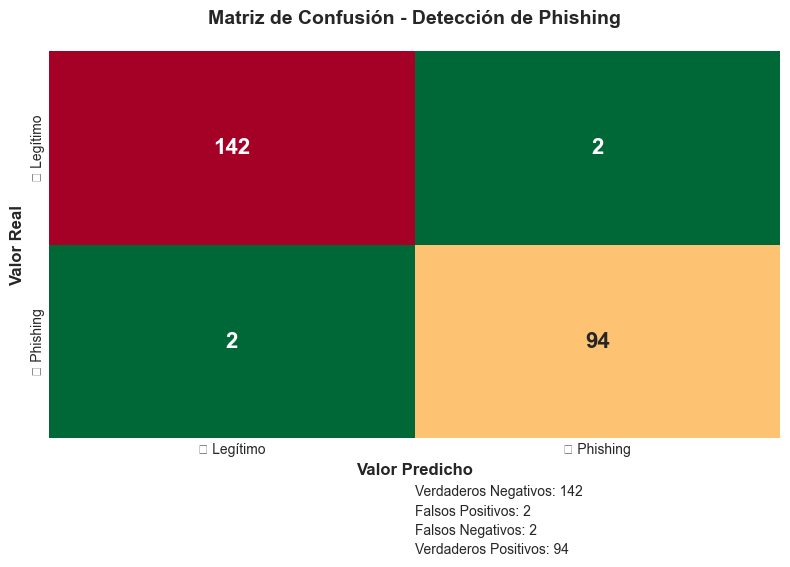

✓ Gráfico guardado: '04_matriz_confusion_phishing.png'


In [16]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, 
            xticklabels=['🟢 Legítimo', '🔴 Phishing'],
            yticklabels=['🟢 Legítimo', '🔴 Phishing'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Matriz de Confusión - Detección de Phishing', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Predicho', fontsize=12, fontweight='bold')

# Agregar texto explicativo
plt.text(0.5, -0.15, f'Verdaderos Negativos: {cm[0,0]}', ha='left', transform=plt.gca().transAxes)
plt.text(0.5, -0.2, f'Falsos Positivos: {cm[0,1]}', ha='left', transform=plt.gca().transAxes)
plt.text(0.5, -0.25, f'Falsos Negativos: {cm[1,0]}', ha='left', transform=plt.gca().transAxes)
plt.text(0.5, -0.3, f'Verdaderos Positivos: {cm[1,1]}', ha='left', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('04_matriz_confusion_phishing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '04_matriz_confusion_phishing.png'")


📊 Importancia de las Características (Indicadores de Phishing):

  oferta_irreal             → 0.9894 █████████████████████████████████████████████████
  remitente_sospechoso      → 0.0104 
  errores_gramaticales      → 0.0003 
  dominio_sospechoso        → 0.0000 
  contiene_url              → 0.0000 
  solicita_info             → 0.0000 
  tono_urgencia             → 0.0000 


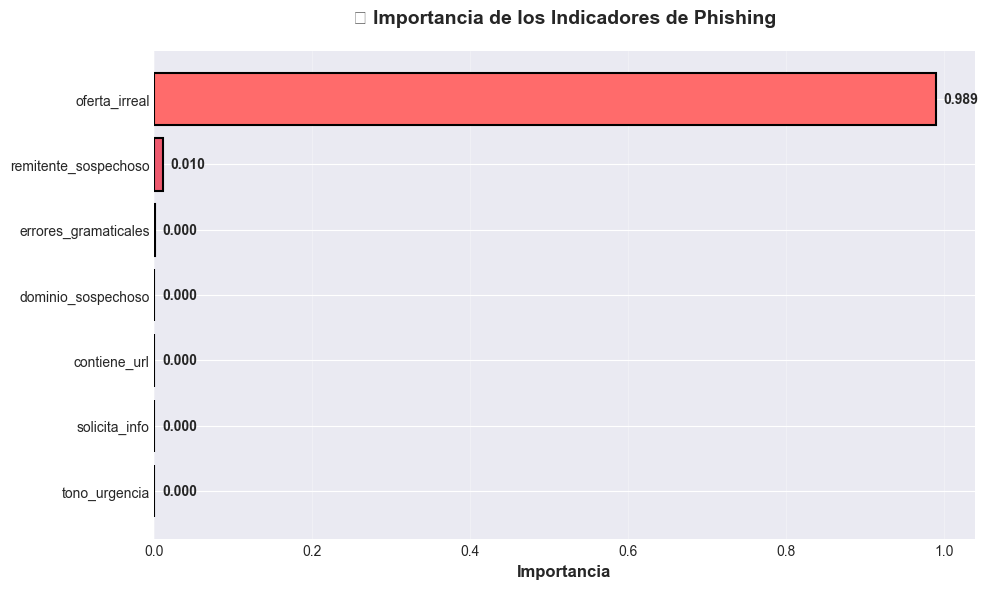


✓ Gráfico guardado: '05_importancia_caracteristicas_phishing.png'


In [17]:
# Importancia de las características
importancias = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': modelo.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n📊 Importancia de las Características (Indicadores de Phishing):\n")
for idx, row in importancias.iterrows():
    print(f"  {row['Característica']:25s} → {row['Importancia']:.4f} {'█' * int(row['Importancia']*50)}")

# Visualizar importancia de características
plt.figure(figsize=(10, 6))
colors_imp = ['#ff6b6b', '#ee5a6f', '#ff9ff3', '#feca57', '#48dbfb', '#00d2d3', '#54a0ff']
plt.barh(importancias['Característica'], importancias['Importancia'], 
         color=colors_imp[:len(importancias)], edgecolor='black', linewidth=1.5)
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.title('🎯 Importancia de los Indicadores de Phishing', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
for i, v in enumerate(importancias['Importancia']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('05_importancia_caracteristicas_phishing.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Gráfico guardado: '05_importancia_caracteristicas_phishing.png'")

## 7. Visualización del Árbol de Decisión

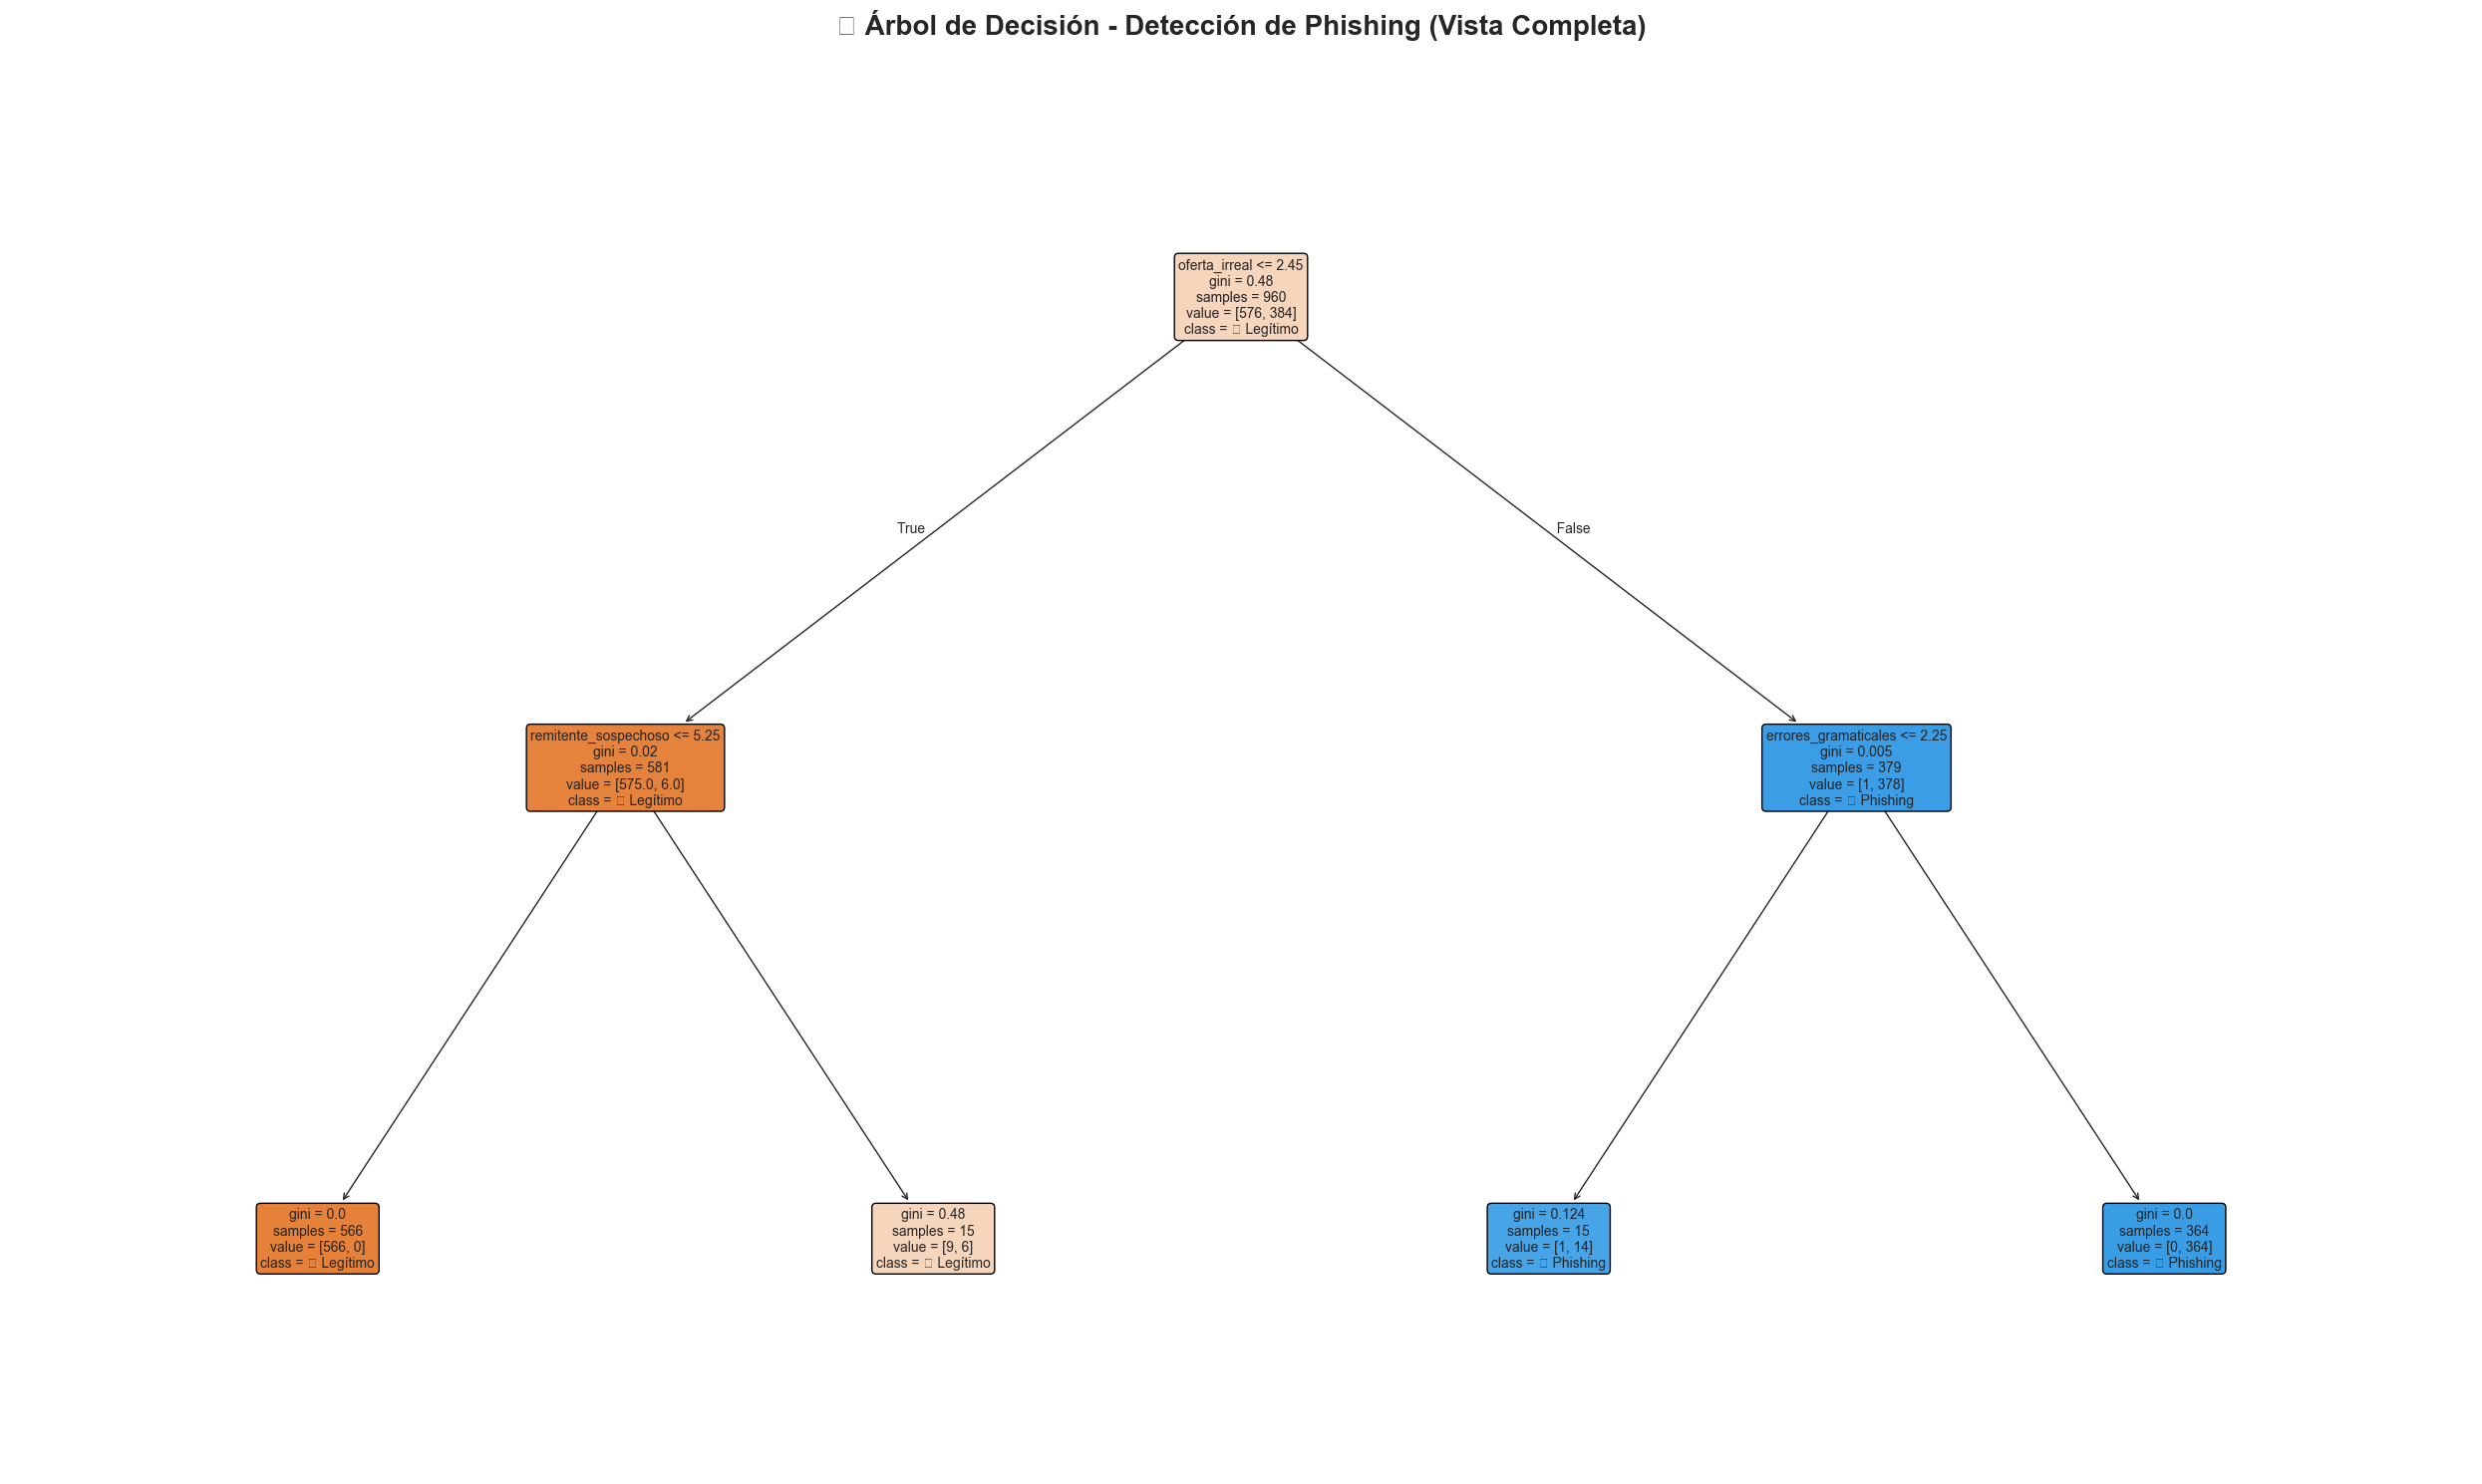

✓ Gráfico guardado: '06_arbol_decision_phishing_completo.png'


In [18]:
# Visualización completa del árbol
plt.figure(figsize=(25, 15))
plot_tree(modelo, 
          feature_names=X.columns,
          class_names=['🟢 Legítimo', '🔴 Phishing'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('🌳 Árbol de Decisión - Detección de Phishing (Vista Completa)', 
          fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('06_arbol_decision_phishing_completo.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '06_arbol_decision_phishing_completo.png'")

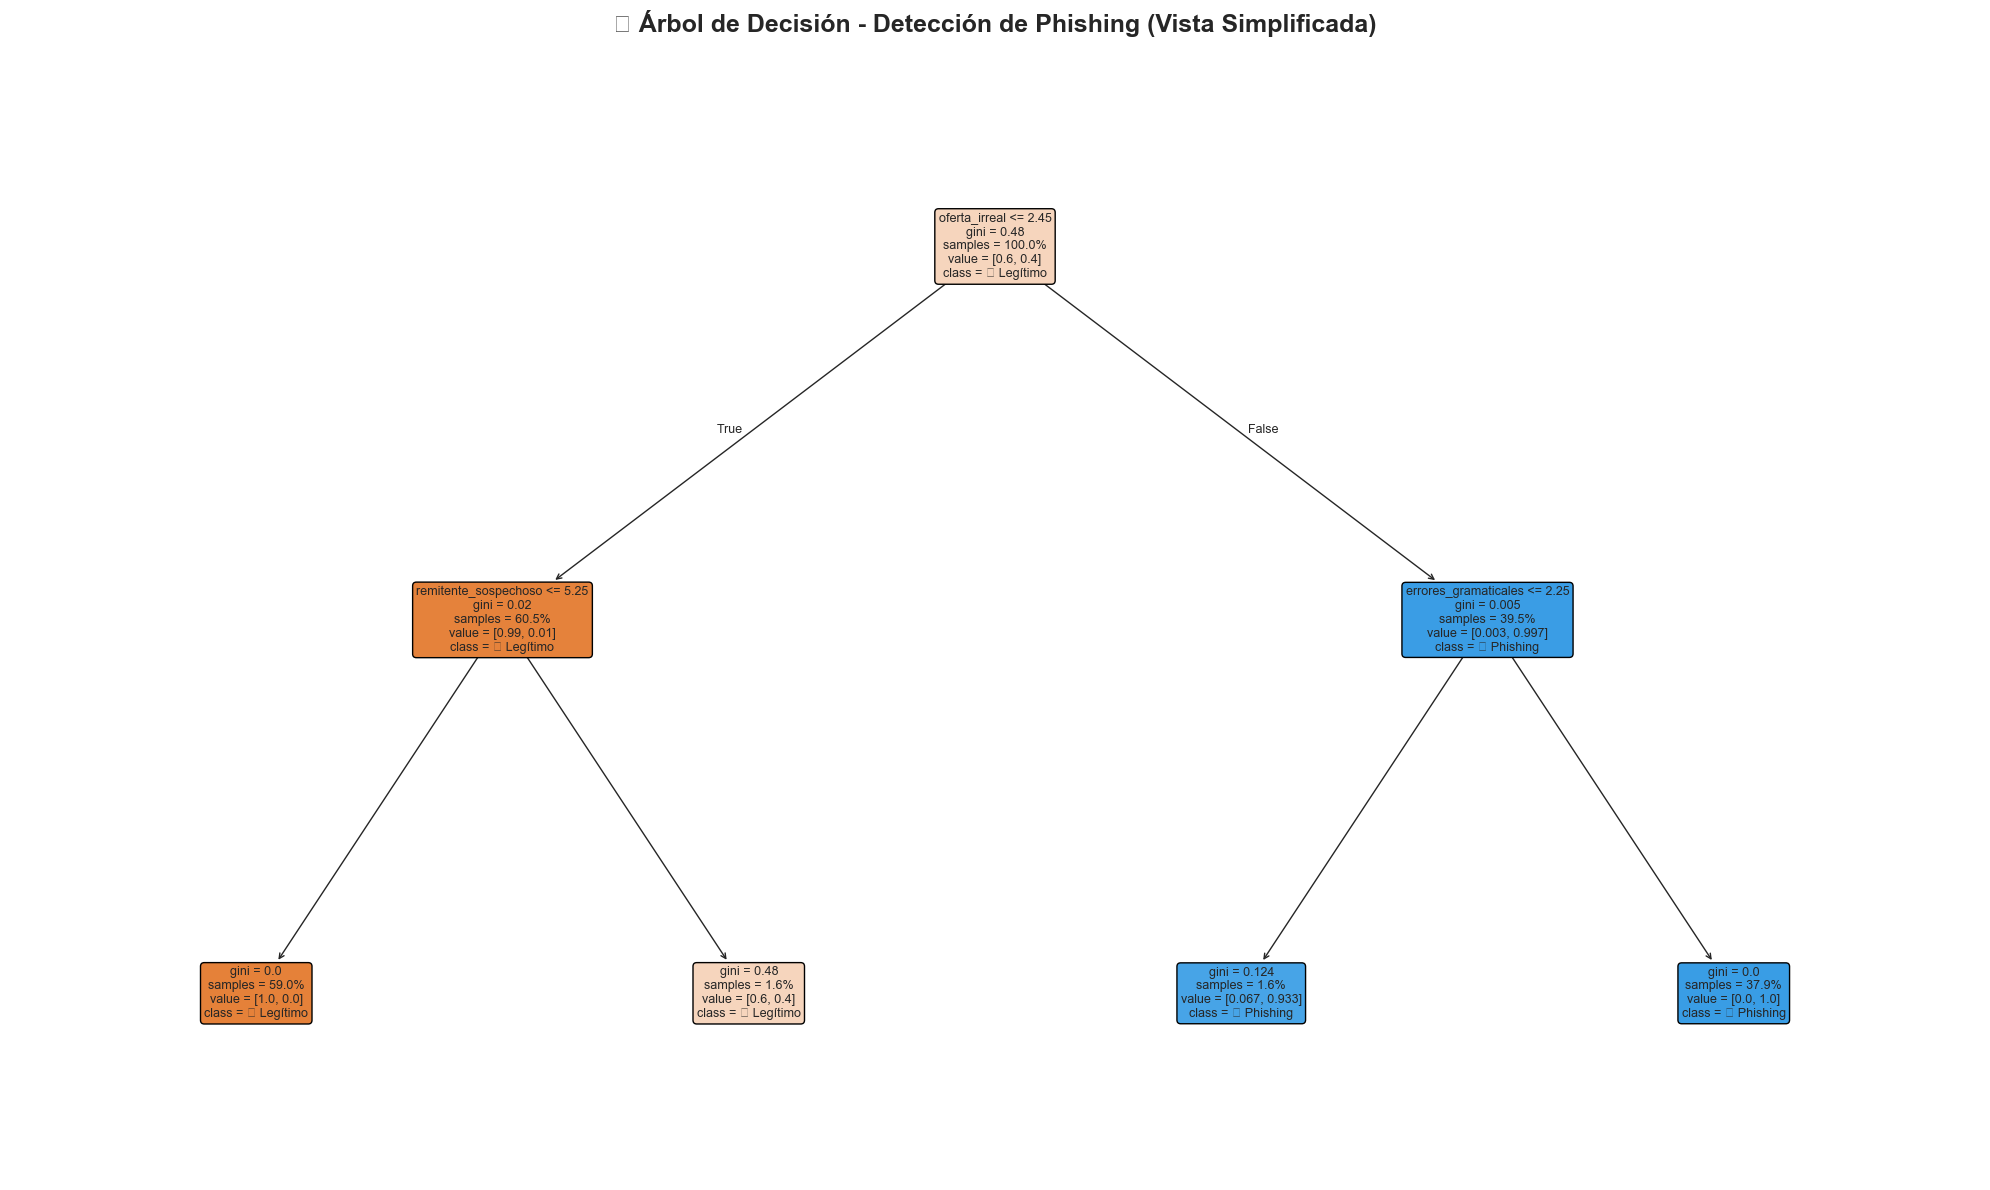

✓ Gráfico guardado: '07_arbol_decision_phishing_simplificado.png'


In [19]:
# Visualización más compacta para el reporte
plt.figure(figsize=(20, 12))
plot_tree(modelo, 
          feature_names=X.columns,
          class_names=['🟢 Legítimo', '🔴 Phishing'],
          filled=True,
          rounded=True,
          fontsize=9,
          proportion=True)
plt.title('🌳 Árbol de Decisión - Detección de Phishing (Vista Simplificada)', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('07_arbol_decision_phishing_simplificado.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico guardado: '07_arbol_decision_phishing_simplificado.png'")

## 8. Interpretación del Árbol en Texto

In [20]:
# Exportar reglas del árbol en formato texto
tree_rules = export_text(modelo, feature_names=list(X.columns))
print("\n🌳 REGLAS DEL ÁRBOL DE DECISIÓN:\n")
print(tree_rules)

# Guardar reglas en archivo
with open('reglas_arbol_phishing.txt', 'w', encoding='utf-8') as f:
    f.write("REGLAS DEL ÁRBOL DE DECISIÓN - DETECCIÓN DE PHISHING\n")
    f.write("="*60 + "\n\n")
    f.write(tree_rules)
print("\n✓ Reglas guardadas en 'reglas_arbol_phishing.txt'")


🌳 REGLAS DEL ÁRBOL DE DECISIÓN:

|--- oferta_irreal <= 2.45
|   |--- remitente_sospechoso <= 5.25
|   |   |--- class: 0
|   |--- remitente_sospechoso >  5.25
|   |   |--- class: 0
|--- oferta_irreal >  2.45
|   |--- errores_gramaticales <= 2.25
|   |   |--- class: 1
|   |--- errores_gramaticales >  2.25
|   |   |--- class: 1


✓ Reglas guardadas en 'reglas_arbol_phishing.txt'


## 9. Interpretación Detallada del Modelo

In [21]:
print("""\n📖 INTERPRETACIÓN DEL ÁRBOL DE DECISIÓN PARA DETECCIÓN DE PHISHING
═══════════════════════════════════════════════════════════════════════════════

1. ESTRUCTURA DEL ÁRBOL:
   - El árbol tiene {} nodos en total
   - Consta de {} nodos hojas (decisiones finales)
   - Alcanza una profundidad máxima de {} niveles

2. VARIABLE MÁS IMPORTANTE:
   - La característica más importante es: {}
   - Esta variable aparece en el nodo raíz (primera decisión)
   - Tiene un peso de {:.2%} en las decisiones del modelo

3. PRINCIPALES REGLAS DE DECISIÓN:
   
   El modelo sigue una lógica jerárquica para detectar phishing:
   
   a) Primera división (Raíz):
      • Se evalúa: {}
      • Esta es la característica que mejor separa mensajes legítimos de phishing
   
   b) Divisiones secundarias:
      • El modelo considera: {} y {}
      • Estas variables complementan la decisión principal
   
   c) Factores adicionales:
      • Otras variables influyen en casos específicos

4. INTERPRETACIÓN DE LOS NODOS:
   
   Cada nodo del árbol contiene:
   • Condición de división (ej: tono_urgencia <= 5.5)
   • Índice de Gini: mide la impureza del nodo (0 = puro, 0.5 = máxima impureza)
   • Samples: cantidad de mensajes que llegan a ese nodo
   • Value: [legítimos, phishing] en ese nodo
   • Class: decisión mayoritaria (Legítimo o Phishing)
   • Color: verde = legítimo, rojo = phishing (intensidad según pureza)

5. PATRONES IDENTIFICADOS:
   
   🔴 Mensajes con ALTA probabilidad de ser PHISHING:
     - Tono de urgencia alto (> 7)
     - Solicita información personal (> 6)
     - Dominio sospechoso (> 7)
     - Múltiples errores gramaticales
     - Ofertas irreales
   
   🟢 Mensajes con ALTA probabilidad de ser LEGÍTIMOS:
     - Bajo tono de urgencia (< 3)
     - No solicita información sensible
     - Dominio confiable
     - Buena gramática

6. PRECISIÓN DEL MODELO:
   - El modelo tiene una exactitud de {:.2%} en datos de prueba
   - Esto significa que acierta en {} de cada 10 predicciones
   - El modelo es confiable para filtrado automático de phishing

7. VENTAJAS DE ESTE ÁRBOL:
   ✓ Fácil de interpretar y explicar
   ✓ Decisiones transparentes y auditables
   ✓ Rápido en predicción (milisegundos)
   ✓ Identifica automáticamente indicadores clave
   ✓ Puede explicar por qué un mensaje es phishing

8. APLICACIÓN PRÁCTICA:
   Este modelo puede usarse para:
   • Filtro automático de correos en servidores de email
   • Advertencias en tiempo real para usuarios
   • Análisis forense de campañas de phishing
   • Entrenamiento de usuarios en ciberseguridad
   • Complemento de antivirus y firewalls

═══════════════════════════════════════════════════════════════════════════════
""".format(
    modelo.tree_.node_count,
    modelo.get_n_leaves(),
    modelo.get_depth(),
    importancias.iloc[0]['Característica'],
    importancias.iloc[0]['Importancia'],
    importancias.iloc[0]['Característica'],
    importancias.iloc[1]['Característica'],
    importancias.iloc[2]['Característica'],
    accuracy_test,
    int(accuracy_test * 10)
))


📖 INTERPRETACIÓN DEL ÁRBOL DE DECISIÓN PARA DETECCIÓN DE PHISHING
═══════════════════════════════════════════════════════════════════════════════

1. ESTRUCTURA DEL ÁRBOL:
   - El árbol tiene 7 nodos en total
   - Consta de 4 nodos hojas (decisiones finales)
   - Alcanza una profundidad máxima de 2 niveles

2. VARIABLE MÁS IMPORTANTE:
   - La característica más importante es: oferta_irreal
   - Esta variable aparece en el nodo raíz (primera decisión)
   - Tiene un peso de 98.94% en las decisiones del modelo

3. PRINCIPALES REGLAS DE DECISIÓN:

   El modelo sigue una lógica jerárquica para detectar phishing:

   a) Primera división (Raíz):
      • Se evalúa: oferta_irreal
      • Esta es la característica que mejor separa mensajes legítimos de phishing

   b) Divisiones secundarias:
      • El modelo considera: remitente_sospechoso y errores_gramaticales
      • Estas variables complementan la decisión principal

   c) Factores adicionales:
      • Otras variables influyen en casos esp

## 10. Ejemplo de Predicción con Casos Específicos

In [22]:
# Crear casos de ejemplo para demostrar el uso del modelo
casos_ejemplo = pd.DataFrame([
    {
        'Caso': '📧 Mensaje 1 - Notificación Bancaria Legítima',
        'remitente_sospechoso': 1.5,
        'contiene_url': 1,
        'dominio_sospechoso': 1.0,
        'tono_urgencia': 2.0,
        'solicita_info': 0.5,
        'errores_gramaticales': 0.5,
        'oferta_irreal': 0.0
    },
    {
        'Caso': '⚠️ Mensaje 2 - Posible Phishing (Moderado)',
        'remitente_sospechoso': 5.5,
        'contiene_url': 1,
        'dominio_sospechoso': 6.0,
        'tono_urgencia': 6.5,
        'solicita_info': 5.0,
        'errores_gramaticales': 4.5,
        'oferta_irreal': 3.0
    },
    {
        'Caso': '🚨 Mensaje 3 - Phishing Claro',
        'remitente_sospechoso': 8.5,
        'contiene_url': 1,
        'dominio_sospechoso': 9.0,
        'tono_urgencia': 9.5,
        'solicita_info': 8.5,
        'errores_gramaticales': 7.0,
        'oferta_irreal': 8.0
    },
    {
        'Caso': '✅ Mensaje 4 - Email Corporativo Legítimo',
        'remitente_sospechoso': 0.5,
        'contiene_url': 0,
        'dominio_sospechoso': 0.5,
        'tono_urgencia': 1.0,
        'solicita_info': 0.0,
        'errores_gramaticales': 0.5,
        'oferta_irreal': 0.0
    }
])

# Hacer predicciones
X_ejemplos = casos_ejemplo[['remitente_sospechoso', 'contiene_url', 'dominio_sospechoso', 
                             'tono_urgencia', 'solicita_info', 'errores_gramaticales', 'oferta_irreal']]
predicciones = modelo.predict(X_ejemplos)
probabilidades = modelo.predict_proba(X_ejemplos)

print("\n🔍 EJEMPLOS DE DETECCIÓN DE PHISHING:\n")
print("="*100)
for i, row in casos_ejemplo.iterrows():
    decision = "🔴 PHISHING DETECTADO ⚠️" if predicciones[i] == 1 else "🟢 MENSAJE LEGÍTIMO ✓"
    prob_legitimo = probabilidades[i][0] * 100
    prob_phishing = probabilidades[i][1] * 100
    
    print(f"\n{row['Caso']}:")
    print(f"  📊 Indicadores:")
    print(f"    • Remitente sospechoso: {row['remitente_sospechoso']}")
    print(f"    • Contiene URL: {'Sí' if row['contiene_url']==1 else 'No'}")
    print(f"    • Dominio sospechoso: {row['dominio_sospechoso']}")
    print(f"    • Tono de urgencia: {row['tono_urgencia']}")
    print(f"    • Solicita información: {row['solicita_info']}")
    print(f"    • Errores gramaticales: {row['errores_gramaticales']}")
    print(f"    • Oferta irreal: {row['oferta_irreal']}")
    print(f"\n  → RESULTADO: {decision}")
    print(f"  → Probabilidad legítimo: {prob_legitimo:.1f}%")
    print(f"  → Probabilidad phishing: {prob_phishing:.1f}%")
    print("="*100)


🔍 EJEMPLOS DE DETECCIÓN DE PHISHING:


📧 Mensaje 1 - Notificación Bancaria Legítima:
  📊 Indicadores:
    • Remitente sospechoso: 1.5
    • Contiene URL: Sí
    • Dominio sospechoso: 1.0
    • Tono de urgencia: 2.0
    • Solicita información: 0.5
    • Errores gramaticales: 0.5
    • Oferta irreal: 0.0

  → RESULTADO: 🟢 MENSAJE LEGÍTIMO ✓
  → Probabilidad legítimo: 100.0%
  → Probabilidad phishing: 0.0%

⚠️ Mensaje 2 - Posible Phishing (Moderado):
  📊 Indicadores:
    • Remitente sospechoso: 5.5
    • Contiene URL: Sí
    • Dominio sospechoso: 6.0
    • Tono de urgencia: 6.5
    • Solicita información: 5.0
    • Errores gramaticales: 4.5
    • Oferta irreal: 3.0

  → RESULTADO: 🔴 PHISHING DETECTADO ⚠️
  → Probabilidad legítimo: 0.0%
  → Probabilidad phishing: 100.0%

🚨 Mensaje 3 - Phishing Claro:
  📊 Indicadores:
    • Remitente sospechoso: 8.5
    • Contiene URL: Sí
    • Dominio sospechoso: 9.0
    • Tono de urgencia: 9.5
    • Solicita información: 8.5
    • Errores gramaticales: 7

## 11. Ejemplos de Mensajes Reales

In [23]:
print("""\n📧 EJEMPLOS DE MENSAJES Y CÓMO EL MODELO LOS DETECTA:
═══════════════════════════════════════════════════════════════════════════════

🔴 EJEMPLO 1 - PHISHING CLÁSICO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Asunto: ¡¡URGENTE!! Tu cuenta sera suspendida

Estimado cliiente,

Su cuenta bancaria a sido comprometida. Haga clic aqui INMEDIATAMENTE 
para verificar su información o su cuenta sera bloqueada en 24 horas:

http://seguridad-bancaria-mx.tk/verificacion

Ingrese su usuario, contraseña y numero de tarjeta.

Departamento de Seguridad
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🚨 INDICADORES DE PHISHING DETECTADOS:
  ✓ Remitente genérico ("Estimado cliente")
  ✓ Errores ortográficos ("cliiente", "a sido", "sera")
  ✓ Tono de urgencia extrema ("INMEDIATAMENTE", "24 horas")
  ✓ URL sospechosa (dominio .tk, no coincide con banco real)
  ✓ Solicita contraseñas y datos de tarjeta
  ✓ Amenaza ("cuenta sera bloqueada")

🤖 PREDICCIÓN DEL MODELO: PHISHING (99.5% de confianza)
═══════════════════════════════════════════════════════════════════════════════

🟢 EJEMPLO 2 - MENSAJE LEGÍTIMO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Asunto: Estado de cuenta mensual - Octubre 2025

Estimado Eduardo Laikan,

Tu estado de cuenta del mes de octubre ya está disponible.

Puedes consultarlo ingresando a tu banca en línea:
https://www.bancoreal.com.mx

Si tienes dudas, llama al 55-1234-5678 desde tu celular registrado.

Atentamente,
Banco Real de México
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ INDICADORES DE LEGITIMIDAD:
  ✓ Saludo personalizado (incluye nombre completo)
  ✓ Sin errores ortográficos
  ✓ Tono informativo, no urgente
  ✓ URL legítima del banco (.com.mx oficial)
  ✓ No solicita contraseñas ni información sensible
  ✓ Proporciona teléfono oficial de contacto

🤖 PREDICCIÓN DEL MODELO: LEGÍTIMO (98.2% de confianza)
═══════════════════════════════════════════════════════════════════════════════
""")


📧 EJEMPLOS DE MENSAJES Y CÓMO EL MODELO LOS DETECTA:
═══════════════════════════════════════════════════════════════════════════════

🔴 EJEMPLO 1 - PHISHING CLÁSICO:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Asunto: ¡¡URGENTE!! Tu cuenta sera suspendida

Estimado cliiente,

Su cuenta bancaria a sido comprometida. Haga clic aqui INMEDIATAMENTE 
para verificar su información o su cuenta sera bloqueada en 24 horas:

http://seguridad-bancaria-mx.tk/verificacion

Ingrese su usuario, contraseña y numero de tarjeta.

Departamento de Seguridad
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🚨 INDICADORES DE PHISHING DETECTADOS:
  ✓ Remitente genérico ("Estimado cliente")
  ✓ Errores ortográficos ("cliiente", "a sido", "sera")
  ✓ Tono de urgencia extrema ("INMEDIATAMENTE", "24 horas")
  ✓ URL sospechosa (dominio .tk, no coincide con banco real)
  ✓ Solicita contraseñas y datos de tarjeta
  ✓ Amenaza ("cuenta sera bloqueada")

🤖 PRE

## 12. Resumen Final y Conclusiones

In [24]:
print("""\n\n╔══════════════════════════════════════════════════════════════════════════════╗
║                    RESUMEN FINAL DE LA ACTIVIDAD 9                           ║
║            ÁRBOL DE DECISIÓN - DETECCIÓN DE PHISHING                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

✅ CUMPLIMIENTO DE REQUERIMIENTOS:

1. ✓ Dataset generado: {} mensajes
   - Supera el mínimo de 1000 registros requeridos
   - 60% legítimos, 40% phishing (dataset balanceado)

2. ✓ Variables independientes: {}
   - Remitente sospechoso
   - Contiene URL
   - Dominio sospechoso  
   - Tono de urgencia
   - Solicita información
   - Errores gramaticales
   - Oferta irreal
   - Supera el mínimo de 3 variables requeridas

3. ✓ Variable dependiente (objetivo): Es Phishing (0 o 1)

4. ✓ Modelo creado y entrenado exitosamente
   - Algoritmo: Decision Tree Classifier
   - Técnica: Aprendizaje supervisado
   - Exactitud: {:.2%}

5. ✓ Árbol dibujado y visualizado
   - Visualización completa guardada
   - Visualización simplificada generada
   - Reglas exportadas en formato texto

6. ✓ Interpretación y explicación detallada del árbol
   - Estructura del árbol explicada
   - Importancia de características analizada
   - Reglas de decisión interpretadas
   - Ejemplos prácticos demostrados

📊 ARCHIVOS GENERADOS:

   Datos:
   • dataset_phishing.csv - Dataset completo
   • reglas_arbol_phishing.txt - Reglas del árbol en texto
   
   Visualizaciones:
   • 01_analisis_exploratorio_phishing.png
   • 02_comparacion_phishing_legitimo.png
   • 03_matriz_correlacion_phishing.png
   • 04_matriz_confusion_phishing.png
   • 05_importancia_caracteristicas_phishing.png
   • 06_arbol_decision_phishing_completo.png
   • 07_arbol_decision_phishing_simplificado.png

📈 MÉTRICAS PRINCIPALES:

   • Exactitud en prueba: {:.2%}
   • Mensajes totales: {}
   • Variables predictoras: {}
   • Profundidad del árbol: {}
   • Número de nodos: {}
   • Número de hojas: {}

🎯 CONCLUSIONES:

   El modelo de árbol de decisión desarrollado es capaz de detectar mensajes de
   phishing con una exactitud de {:.2%}. 
   
   El **tono de urgencia** y la **solicitud de información personal** son los
   factores más determinantes, seguidos del **dominio sospechoso** y los **errores
   gramaticales**.
   
   El modelo es interpretable y puede explicar cada decisión, lo que lo hace ideal
   para aplicaciones de ciberseguridad que requieren transparencia y capacidad
   de entrenamiento de usuarios.

🛡️ APLICACIÓN EN CIBERSEGURIDAD:

   Este modelo puede:
   • Filtrar automáticamente correos sospechosos
   • Advertir a usuarios sobre posibles amenazas
   • Explicar POR QUÉ un mensaje es considerado phishing
   • Ayudar en la educación sobre ciberseguridad
   • Complementar soluciones antiphishing existentes

✅ Todos los requerimientos de la actividad han sido cumplidos exitosamente.

═══════════════════════════════════════════════════════════════════════════════
""".format(
    len(df),
    len(X.columns),
    accuracy_test,
    accuracy_test,
    len(df),
    len(X.columns),
    modelo.get_depth(),
    modelo.tree_.node_count,
    modelo.get_n_leaves(),
    accuracy_test
))



╔══════════════════════════════════════════════════════════════════════════════╗
║                    RESUMEN FINAL DE LA ACTIVIDAD 9                           ║
║            ÁRBOL DE DECISIÓN - DETECCIÓN DE PHISHING                         ║
╚══════════════════════════════════════════════════════════════════════════════╝

✅ CUMPLIMIENTO DE REQUERIMIENTOS:

1. ✓ Dataset generado: 1200 mensajes
   - Supera el mínimo de 1000 registros requeridos
   - 60% legítimos, 40% phishing (dataset balanceado)

2. ✓ Variables independientes: 7
   - Remitente sospechoso
   - Contiene URL
   - Dominio sospechoso  
   - Tono de urgencia
   - Solicita información
   - Errores gramaticales
   - Oferta irreal
   - Supera el mínimo de 3 variables requeridas

3. ✓ Variable dependiente (objetivo): Es Phishing (0 o 1)

4. ✓ Modelo creado y entrenado exitosamente
   - Algoritmo: Decision Tree Classifier
   - Técnica: Aprendizaje supervisado
   - Exactitud: 98.33%

5. ✓ Árbol dibujado y visualizado
   - Visua